In [20]:
# -*- coding: utf-8 -*-
"""
@author: Ali Mirzaei
"""

from __future__ import print_function
import numpy as np
from keras.layers import Input, Conv2D, merge
from keras.models import Model
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import h5py
import math
from scipy import io
from copy import copy
from scipy import misc

In [21]:
Data_file = 'Ch_real_VehA_14.mat'
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true)))/K.log(10.)

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 20
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [58]:
def getModel():
    #input imaage dimensions
    img_rows, img_cols = 72, 14
    out_rows, out_cols = 72, 14
    #filter number
    n1 = 64
    n2 = 32
    n3 = 2
    #filter size
    f1 = 9
    f2 = 1
    f3 = 5
    initializer = 'zeros' #'he_normal'
    x = Input(shape = (72, 14, 2))
    c1 = Conv2D(n1, (6, 4), activation = 'relu', kernel_initializer = initializer , padding='same')(x)
    c2 = Conv2D(n2, (1, 1), activation = 'relu', kernel_initializer = initializer, padding='same')(c1)
    c3 = Conv2D(n3, (3, 2), kernel_initializer = initializer, padding='same')(c2)
    model = Model(x, c3)
    model.summary()
    ##compile
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) 
    model.compile(loss='mse', metrics=[PSNRLoss], optimizer=adam)  
    return model

In [60]:
model = getModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 72, 14, 2)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 72, 14, 64)        3136      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 14, 32)        2080      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 72, 14, 2)         386       
Total params: 5,602
Trainable params: 5,602
Non-trainable params: 0
_________________________________________________________________


In [61]:

##load train data
channels = io.loadmat(Data_file)['channels']
reals = np.real(channels)
imags = np.imag(channels)

# desire outputs
out_train = np.zeros(reals.shape+(2,))
out_train[:,:,:,0] = reals
out_train[:,:,:,1] = imags

In [62]:
max_out = np.max(out_train)
min_out = np.min(out_train)

# normalize training samples
out_train = (out_train-min_out)/(max_out-min_out)

In [63]:
sampled = copy(out_train[:,1::6, 1::4,:])

In [54]:
noisy_sampled = sampled + .05*np.random.randn(*sampled.shape)

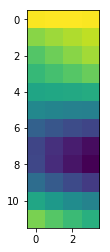

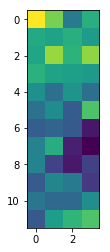

In [55]:
plt.imshow(sampled[0,:,:,0])
plt.show()
plt.imshow(noisy_sampled[0,:,:,0])
plt.show()

In [56]:
# resize images to original size
in_train = np.zeros(out_train.shape)
for i,im in enumerate(noisy_sampled):
    in_train[i,:,:,0] = misc.imresize(im[:,:,0], size=(72,14))
    in_train[i,:,:,1] = misc.imresize(im[:,:,1], size=(72,14))

C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.
C:\Users\Ali\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


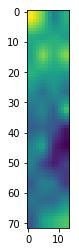

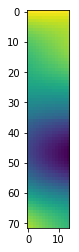

In [64]:
plt.imshow(in_train[0,:,:,0])
plt.show()
plt.imshow(out_train[0,:,:,0])
plt.show()

In [71]:
input_shape = (72, 14, 2)
batch_size = 64
nb_epoch = 1

#print number of training patches
print('in_train shape:', in_train.shape)
print(in_train.shape[0], 'train samples')
#SR Model
#input tensor for a 1_channel image region

# learning schedule callback
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]
history = model.fit(in_train, out_train, batch_size=batch_size, epochs=nb_epoch, callbacks = [lrate],
          verbose=1,validation_split=0.15)    

in_train shape: (40000, 72, 14, 2)
40000 train samples
Train on 34000 samples, validate on 6000 samples
Epoch 1/1
34000/34000 [==============================] - 152s - loss: 0.0122 - PSNRLoss: 19.1501 - val_loss: 0.0119 - val_PSNRLoss: 19.2836


dict_keys(['val_loss', 'val_PSNRLoss', 'loss', 'PSNRLoss'])


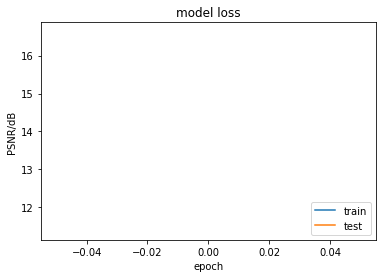

In [47]:
print(history.history.keys())
#save model and weights
json_string = model.to_json()  
open('srcnn_model.json','w').write(json_string)  
model.save_weights('srcnn_model_weights.h5') 
# summarize history for loss
plt.plot(history.history['PSNRLoss'])
plt.plot(history.history['val_PSNRLoss'])
plt.title('model loss')
plt.ylabel('PSNR/dB')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [72]:
out_p = model.predict(in_train[0:1])

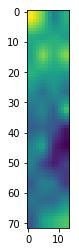

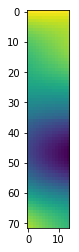

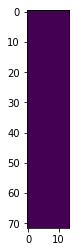

In [73]:
plt.imshow(in_train[0,:,:,0])
plt.show()

plt.imshow(out_train[0,:,:,0])
plt.show()

plt.imshow(out_p[0,:,:,0])
plt.show()


In [75]:
np.min(out_p)

0.47538894